In [76]:
%matplotlib inline
import sys
import random
from math import floor
import numpy as np
import numpy.random as nr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os, glob, math,time
from scipy import misc
import torch
import torch as tc
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import transforms, utils
from torchvision import models


from PIL import Image

import sys


sys.path.append('/home/r120084/pytorch_lib/pytorch/')
import lib.pytorch_trainer as ptt



from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

from tqdm import tqdm 
from sklearn.preprocessing import MultiLabelBinarizer

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False



# Choose dataset 

In [77]:
path2data = "/home/e209440/data/my_distract_driver_data.npy"

# Dataset Class with split data, transformations and onehot code 

In [78]:
class KaggleSafeDriverDataset(Dataset):
    """
    Arguments:
        Path to data (redux or not)
        PIL transforms
        Test data (boolean)
        Validation data (boolean)
        Size of validation data 
        Shuffle indices of validation and Train
        
    """

    def __init__(self, data_path, use_only =1.0, transforms=None, \
                 is_test=False,is_val=False,val_size=0.2):
    
        tmp_data = np.load(data_path).item()

        self.transform = transforms
        self.mlb = MultiLabelBinarizer()
        
        if is_test:
            
            length = len(tmp_data['X_test'])
            only = int(use_only * length)
            self.X = tmp_data['X_test'][:only]
            
            self.y = None #Gambiarra para poder criar DataSet do Test.
        
        else:
            
            length = len(tmp_data['X_train'])
            indices = list(range(0,length))
            
            nr.seed(4572)
            ind = nr.permutation(indices)
            
            
            length = ind.shape[0]
            only = int(use_only * length)
            
            ind = ind[:only]
            length = ind.shape[0]
            
            split = int(val_size * length)
            
            if is_val:
                self.X = [tmp_data['X_train'][i] for i in ind[:split]]
                self.y = [tmp_data['y_train'][i] for i in ind[:split]]
            else:
                self.X = [tmp_data['X_train'][i] for i in ind[split:]]
                self.y = [tmp_data['y_train'][i] for i in ind[split:]]
                
    def __getitem__(self, index):
        path = self.X[index]
        label = self.y[index]
        with open(path, 'rb') as f:
            with Image.open(f) as img:
                image = img.convert('RGB')                
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.X)
    

In [79]:
batch_size = 250
img_size ,img_width, img_height = 50, 50, 50
use_only = 0.1 # Use only 20% of the full dataset

labels = {  'c0' : 'safe driving', 
            'c1' : 'texting - right', 
            'c2' : 'talking on the phone - right', 
            'c3' : 'texting - left', 
            'c4' : 'talking on the phone - left', 
            'c5' : 'operating the radio', 
            'c6' : 'drinking', 
            'c7' : 'reaching behind', 
            'c8' : 'hair and makeup', 
            'c9' : 'talking to passenger'}

In [80]:
def my_transforms(img, img_width=img_width, img_height=img_height):
    return img.resize((img_width, img_height))

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

def denormalize(image, mean=imagenet_mean, std=imagenet_std):
    inp = image.transpose((1, 2, 0))
    img = std * inp + mean
    return img


In [81]:
# Data augmentation and normalization for training 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
    'valid': transforms.Compose([
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
}


In [82]:
dsets = {
    'train': KaggleSafeDriverDataset(path2data, transforms=data_transforms['train'],use_only=use_only),
    'valid': KaggleSafeDriverDataset(path2data, transforms=data_transforms['valid'],use_only=use_only, is_val=True, val_size=0.2),
    'test':  KaggleSafeDriverDataset(path2data, transforms=data_transforms['valid'],use_only=use_only, is_test=True),
}

In [83]:
dset_loaders = {
    'train': tc.utils.data.DataLoader(dsets['train'], batch_size=batch_size, shuffle=True, num_workers=4), # 1 for CUDA # pin_memory=True # CUDA only
    'valid': tc.utils.data.DataLoader(dsets['valid'], batch_size=batch_size, shuffle=True,num_workers=4),
    'test':  tc.utils.data.DataLoader(dsets['test'],  batch_size=batch_size, shuffle=False,num_workers=4),
}

In [84]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'valid', 'test']}
dset_classes = len(dsets['train'].y)
dset_classes, dset_sizes

# Datates has much more samples than datatrain ***It comes from the test.zip****

(1794, {'test': 7972, 'train': 1794, 'valid': 448})

# Plotting some examples

In [85]:
def plot_classes(dset_loaders, labels):

    # Get a batch of training data
    inputs, cls = next(iter(dset_loaders))
    print(inputs[8].shape, cls.shape)
    fig = plt.figure(figsize=(15,6))
    for i, j in enumerate(range(0,10)):
        fig.add_subplot(2,5, i+1)
        img = denormalize(inputs.numpy()[j])
        plt.imshow(img)
        plt.title('{}'.format(labels['c'+str(cls[j])]))
        plt.axis('off')

torch.Size([3, 50, 50]) torch.Size([250])


/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


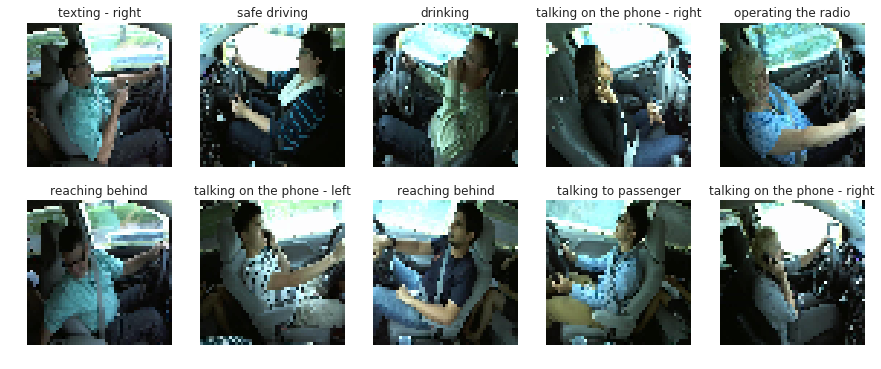

In [86]:
plot_classes(dset_loaders['train'], labels)

# Data Analysis

In [87]:
def de_para(dataset, labels): 
    class_str = []
    for item in dataset.y:
        class_str.append(labels['c'+str(item)])
            
    return class_str        
    

In [89]:
class_str = de_para(dsets['train'], labels)

/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


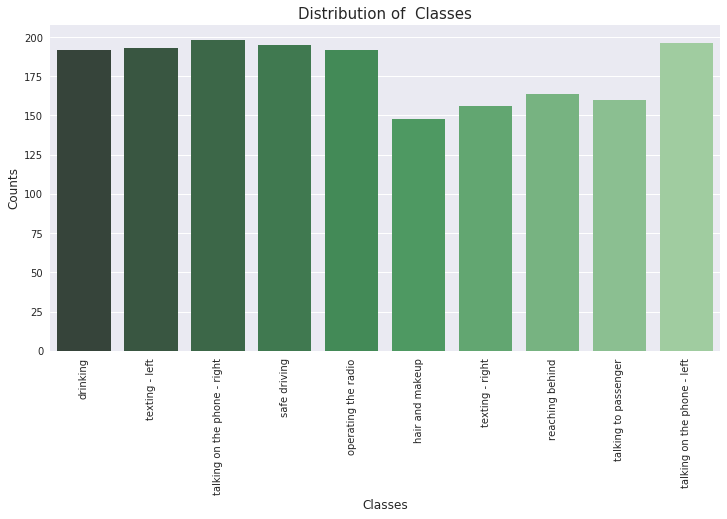

In [90]:
plt.figure(figsize=(12,6))
sns.countplot(x=class_str, palette="Greens_d");
plt.xlabel("Classes", fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.xticks(rotation=90)
plt.title("Distribution of  Classes", fontsize=15)
plt.show()

In [ ]:
nb_classes = len(set(class_str))

In [ ]:
class MyResNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet34(pretrained=True)    
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        n_feat = self.resnet.fc.in_features
        fc_old = self.resnet.fc.state_dict()            
        fc_new = dict(weight=fc_old['weight'][(284, 208), :], bias=fc_old['bias'][(284, 208),])

        self.resnet.fc = nn.Linear(n_feat, 2)
        self.resnet.fc.load_state_dict(fc_new)

    def forward(self, input_):
        return self.resnet.forward(input_)
    
resNetModel = MyResNet()
if use_gpu:
    resNetModel = resNetModel.cuda()

In [ ]:
class myconvNet(nn.Module):
    def __init__(self, image_size=(3,50,50)):
        super(myconvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        
        
        feature_size = self._get_conv_output(image_size)
        
        self.dense1 = nn.Linear(feature_size, 250)
        self.dense2 = nn.Linear(250, 125)
        self.dense3 = nn.Linear(125, nb_classes)
        
    def _get_conv_output(self, shape):
        bs = 1
        input = Variable(tc.rand(bs, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size

    def _forward_features(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x))
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
       
        return x
    
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.dense1(x))
        x = F.dropout(x, p=0.25, training=self.training)
        x = F.relu(self.dense2(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.dense3(x))
        return F.softmax(x)


myconvNet = myconvNet()
if use_gpu:
    myconvNet = myconvNet.cuda()

In [ ]:
optimizer =  optim.Adam(myconvNet.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=5, gamma=0.75)
loss_function = nn.CrossEntropyLoss()

In [ ]:
param = {'model' : myconvNet, 
    'criterion': loss_function,  
    'optimizer': optimizer, 
    'callbacks': [ptt.PlotCallback(), ptt.PrintCallback()]
        }

In [ ]:
#trainer = ptt.DeepNetTrainer()

In [ ]:
#trainer.fit_loader(2, dset_loaders['train'], dset_loaders['valid'])